In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import wandb
from torch.optim import Adam
from tqdm import tqdm
from dotenv import load_dotenv

from transformers import RobertaModel, RobertaTokenizer
from torch.utils.data.sampler import WeightedRandomSampler

/home/mdafifal.mamun/miniconda3/envs/trx/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/mdafifal.mamun/miniconda3/envs/trx/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/mdafifal.mamun/miniconda3/envs/trx/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
torch.cuda.is_available()

True

In [3]:
load_dotenv()

True

In [5]:
# wandb.login()

In [4]:
def load_dataframe(path: str) -> pd.DataFrame:
    return pd.read_csv(path)

In [5]:
def clean_data(df):
    df['text'] = df['text'].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', regex=True)
    df["text"] = df['text'].str.replace(" +", " ", regex=True)

    return df
    
def prepare_dataframe(df: pd.DataFrame, minimum_contribution = 0) -> pd.DataFrame:
    developers = df["assignees"].value_counts()
    df = df[df["assignees"].notna()]
    filtered_developers = developers.index[developers >= minimum_contribution]
    df = df[df["assignees"].isin(filtered_developers)]
    # df = df[df.apply(lambda x: "pull" not in str(x.issue_url), axis=1)]

    df["text"] = df.apply(
            lambda x: "Title: "
            + str(x["issue_title"])
            + "\nLabels: "
            + str(x["labels"])
            + "\nDescription: "
            + str(x["issue_body"]),
            axis=1,
        )
    
    # df = df[df.issue_state == "closed"]
    # min_length = 15
    # df = df[df["text"].str.len().gt(min_length)]

    df["owner_id"] = pd.factorize(df["assignees"])[0]

    return df

In [6]:
data_path = "/home/mdafifal.mamun/notebooks/triagerX/notebook/data/openj9/openj9_topic_kmeans_issues.csv"

df = load_dataframe(data_path)
print(len(df))
df = prepare_dataframe(df, minimum_contribution=5)
print(len(df))
df = clean_data(df)
print(len(df))

5521
3365
3365


In [9]:
len(df["assignees"].unique())

95

In [10]:
len(df["assignees"].unique())

95

In [11]:
print(len(df))

3365


In [13]:
df.assignees.value_counts()

JasonFengJ9    307
pshipton       279
keithc-ca      225
babsingh       204
hangshao0       98
              ... 
terryzuoty       5
OscarQQ          5
kangyining       5
doomerxe         5
caohaley         5
Name: assignees, Length: 95, dtype: int64

<Axes: ylabel='assignees'>

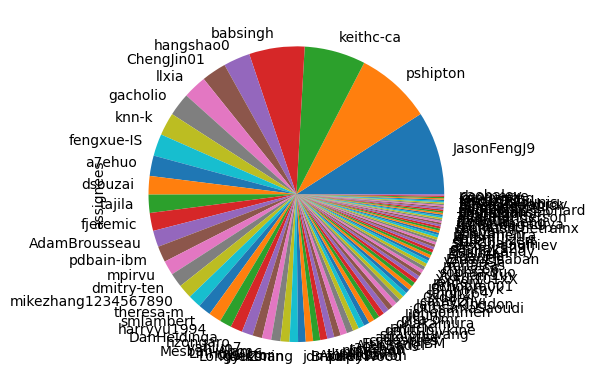

In [12]:
df["assignees"].value_counts().plot(kind="pie")

In [14]:
df.assignees.unique()

array(['pshipton', 'keithc-ca', 'Mesbah-Alam', 'alexey-anufriev',
       'EricYangIBM', 'a7ehuo', 'theresa-m', 'hangshao0', 'OussamaSaoudi',
       'mpirvu', 'knn-k', 'llxia', 'tajila', 'adamfarley', 'yanluo7',
       'vsebe', 'ChengJin01', 'jdekonin', 'mikezhang1234567890',
       'JasonFengJ9', 'AdamBrousseau', 'RSalman', 'gacholio', 'smlambert',
       'ymanton', 'dmitry-ten', 'cedrichansen', 'DanHeidinga', 'VermaSh',
       'EmanElsaban', 'SueChaplain', 'kgibm', 'dnakamura', 'AlenBadel',
       'dsouzai', 'qasimy123', 'babsingh', 'harryyu1994', 'rmnattas',
       'LinHu2016', 'Akira1Saitoh', 'JamesKingdon', 'BradleyWood',
       'fjeremic', 'IBMJimmyk', 'singh264', '0xdaryl', '0dvictor',
       'sharon-wang', 'liqunl', 'AlexeyKhrabrov', 'jdmpapin',
       'dchopra001', 'taliamccormick', 'sophia-guo', 'dmitripivkine',
       'LongyuZhang', 'gita-omr', 'fengxue-IS', 'chrisc66', 'terryzuoty',
       'andrew-m-leonard', 'amicic', 'bhavanisn', 'jonoommen', 'hzongaro',
       'r30shah', 

In [15]:
df.iloc[0]

Unnamed: 0.1                                                    0
Unnamed: 0                                                      0
issue_number                                                 1000
issue_url       https://github.com/eclipse-openj9/openj9/issue...
issue_title     OpenJ9 JDK8 builds fail to run Apache Spark du...
issue_body      Attempting to run Spark 2.2.1 results in the f...
issue_state                                                closed
creator                                                   ymanton
assignees                                                pshipton
labels                                                    blocker
topic_id                                                        0
topic_label                                       Building OpenJ9
text            Title: OpenJ9 JDK8 builds fail to run Apache S...
owner_id                                                        0
Name: 0, dtype: object

In [16]:
df["topic_hot"] = pd.get_dummies(df["topic_id"]).values.tolist()

In [17]:
num_cv = 10
# sample_threshold=20
samples_per_block = len(df) // num_cv + 1
print(f"Samples per block: {samples_per_block}")

block = 9
sliced_df = df[: samples_per_block * (block+1)]

Samples per block: 337


In [18]:
len(sliced_df)

3365

In [19]:
# sliced_df["representations"] = list(probs)

X_df = sliced_df[:samples_per_block*block]
y_df = sliced_df[samples_per_block*block : samples_per_block * (block+1)]

print(len(X_df), len(y_df))

developers = X_df["assignees"].value_counts()
# filtered_developers = developers.index[developers >= sample_threshold]
# X_df = X_df[X_df["assignees"].isin(filtered_developers)]

# train_developers = X_df.owner.unique()
# topic_owner = X_df.groupby("owner")["topic_label"].value_counts()
# topic_owner = topic_owner[topic_owner > 5]
# X_df = X_df[X_df.apply(lambda x: (x['owner'], x['topic_label']) in topic_owner.index, axis=1)]

train_owners = set(X_df["assignees"])
test_owners = set(y_df["assignees"])

# print(len(train_owners), len(test_owners))

unwanted = list(test_owners - train_owners)
# print(len(unwanted))

y_df = y_df[~y_df["assignees"].isin(unwanted)]

print(f"Training data: {len(X_df)}, Validation data: {len(y_df)}")
print(f"Number of developers: {len(X_df.assignees.unique())}")

3033 332
Training data: 3033, Validation data: 332
Number of developers: 95


In [20]:
lbl2idx = {}

train_owners = sorted(train_owners)

for idx, dev in enumerate(train_owners):
    lbl2idx[dev] = idx

In [21]:
X_df["owner_id"] = X_df["assignees"].apply(lambda owner: lbl2idx[owner])
y_df["owner_id"] = y_df["assignees"].apply(lambda owner: lbl2idx[owner])

/tmp/ipykernel_1302682/3227984889.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_df["owner_id"] = X_df["assignees"].apply(lambda owner: lbl2idx[owner])


In [22]:
X_df.iloc[0]

Unnamed: 0.1                                                    0
Unnamed: 0                                                      0
issue_number                                                 1000
issue_url       https://github.com/eclipse-openj9/openj9/issue...
issue_title     OpenJ9 JDK8 builds fail to run Apache Spark du...
issue_body      Attempting to run Spark 2.2.1 results in the f...
issue_state                                                closed
creator                                                   ymanton
assignees                                                pshipton
labels                                                    blocker
topic_id                                                        0
topic_label                                       Building OpenJ9
text            Title: OpenJ9 JDK8 builds fail to run Apache S...
owner_id                                                       76
topic_hot       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: 0, d

<Axes: >

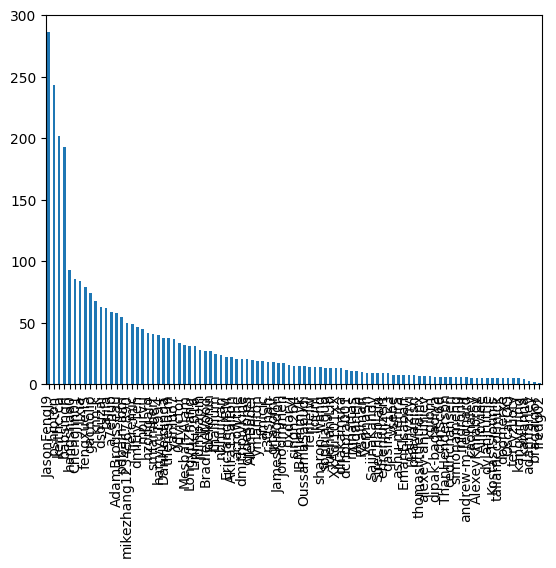

In [23]:
X_df.assignees.value_counts().plot(kind="bar")

In [24]:
# counts = np.bincount(X_train["owner_id"])
# labels_weights = 1. / counts
# weights = labels_weights[X_train["owner_id"]]
# sampler = WeightedRandomSampler(weights, len(weights))

In [24]:
import pandas as pd
import numpy as np
from loguru import logger
from torch.utils.data import Dataset

from transformers import PreTrainedTokenizer


class TriageDataset(Dataset):
    def __init__(
        self,
        df: pd.DataFrame,
        tokenizer: PreTrainedTokenizer,
        feature: str = "text",
        target: str = "owner_id",
    ):
        logger.debug("Generating torch dataset...")
        self.tokenizer = tokenizer
        self.labels = [label for label in df[target]]
        # self.embedding_model = SentenceTransformer("BAAI/bge-small-en")
        logger.debug("Tokenizing texts...")
        self.texts = [
            (row.text, self.tokenizer(
                row.text,
                padding="max_length",
                max_length=512,
                truncation=True,
                return_tensors="pt",
            ), torch.tensor(row.topic_hot))
            for _, row in df.iterrows()
        ]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y


In [25]:
import torch
import torch.nn.functional as F
from torch import nn
from transformers import AutoModel, AutoTokenizer


class LBTPClassifierTopic(nn.Module):
    def __init__(
        self, output_size, topic_size, unfrozen_layers=4, embed_size=1024, dropout=0.1
    ) -> None:
        super().__init__()
        model_name = "microsoft/deberta-large"
        self.base_model = AutoModel.from_pretrained(
            model_name, output_hidden_states=True
        )
        self._tokenizer = AutoTokenizer.from_pretrained(model_name)

        # Freeze embedding layers
        for p in self.base_model.embeddings.parameters():
            p.requires_grad = False

        # Freeze encoder layers till last {unfrozen_layers} layers
        for i in range(0, 24 - unfrozen_layers):
            for p in self.base_model.encoder.layer[i].parameters():
                p.requires_grad = False

        filter_sizes = [3, 4, 5, 6]
        self._num_filters = 256
        self._max_tokens = 512
        self._embed_size = embed_size
        self.unfrozen_layers = unfrozen_layers
        self.conv_blocks = nn.ModuleList(
            [
                nn.ModuleList(
                    [
                        nn.Sequential(
                            nn.Conv2d(1, self._num_filters, (K, embed_size)),
                            nn.BatchNorm2d(self._num_filters),
                            nn.ReLU(),
                            nn.Flatten(),
                            nn.MaxPool1d(self._max_tokens - (K - 1)),
                            nn.Flatten(start_dim=1),
                        )
                        for K in filter_sizes
                    ]
                )
                for _ in range(unfrozen_layers)
            ]
        )

        self.classifiers = nn.ModuleList(
            [
                nn.Linear(
                    len(filter_sizes) * self._num_filters + topic_size, output_size
                )
                for _ in range(unfrozen_layers)
            ]
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids, attention_mask, tok_type, topic_id):
        outputs = []

        base_out = self.base_model(input_ids=input_ids, token_type_ids=tok_type, attention_mask=attention_mask)
        # pooler_out = base_out.last_hidden_state.squeeze(0)
        hidden_states = base_out.hidden_states[-self.unfrozen_layers :]

        for i in range(self.unfrozen_layers):
            batch_size, sequence_length, hidden_size = hidden_states[i].size()
            x = [
                conv(hidden_states[i].view(batch_size, 1, sequence_length, hidden_size))
                for conv in self.conv_blocks[i]
            ]
            x = torch.cat(x, dim=1)
            # print(x.shape, pooler_out.shape)
            # x = torch.cat([pooler_out, x], dim=1)
            x = self.dropout(x)
            x = torch.cat([x, topic_id], dim=1)
            x = self.classifiers[i](x)

            outputs.append(x)

        return outputs

    def tokenizer(self) -> AutoTokenizer:
        return self._tokenizer


In [26]:
class CombineLoss(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self._ce = nn.CrossEntropyLoss()

    def forward(
        self,
        prediction,
        labels
    ) -> torch.Tensor:
        loss = 0

        for i in range(len(prediction)):
            loss += self._ce(prediction[i], labels)
            # print(loss)

        return loss

In [27]:
from torch.optim import AdamW

In [28]:
from torch.optim.lr_scheduler import ReduceLROnPlateau


class_counts = np.bincount(X_df["owner_id"])
num_samples = sum(class_counts)
labels = X_df["owner_id"].to_list() # corresponding labels of samples

class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
weights = [class_weights[labels[i]] for i in range(int(num_samples))]
sampler = WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))
weights_save_location = f"deberta_cv{block}.pt"

# Define hyperparameters
learning_rate = 1e-5
epochs = 12
batch_size = 15

model = LBTPClassifierTopic(len(X_df.owner_id.unique()), 20, dropout=0.3)
criterion = CombineLoss()
optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8, weight_decay=0.001)
scheduler = ReduceLROnPlateau(optimizer, "min", patience=2, factor=0.1, threshold=1e-8)
# scheduler = get_linear_schedule_with_warmup(optimizer=optimizer, num_warmup_steps=2, )

In [29]:
# Prepare torch dataset from train and validation splits
train = TriageDataset(X_df, model.tokenizer())
val = TriageDataset(y_df, model.tokenizer())

2024-03-20 15:40:40.038 | DEBUG    | __main__:__init__:17 - Generating torch dataset...
2024-03-20 15:40:40.040 | DEBUG    | __main__:__init__:21 - Tokenizing texts...
2024-03-20 15:40:47.700 | DEBUG    | __main__:__init__:17 - Generating torch dataset...
2024-03-20 15:40:47.702 | DEBUG    | __main__:__init__:21 - Tokenizing texts...


In [30]:
from torch.utils.data import Dataset, DataLoader

In [31]:
train_dataloader = DataLoader(
    dataset=train,
    batch_size=10,
    shuffle=False if sampler else True,
    sampler=sampler,
)
val_dataloader = DataLoader(val, batch_size=10)

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_loss = float("inf")

if torch.cuda.is_available():
    logger.debug(f"Selected compute device: {device}")
    model = model.cuda()
    criterion = criterion.cuda()

2024-03-20 15:40:48.487 | DEBUG    | __main__:<module>:5 - Selected compute device: cuda


In [33]:
def log_step(
        epoch_num,
        total_acc_train,
        total_acc_val,
        total_loss_train,
        total_loss_val,
        precision,
        recall,
        f1_score,
        train_data,
        validation_data,
        topk,
    ):
        log = f"Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                    | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                    | Val Loss: {total_loss_val / len(validation_data): .3f} \
                    | Val Accuracy: {total_acc_val / len(validation_data): .3f} \
                    | Top 10: {topk} \
                    | Precision: {precision: .3f} \
                    | Recall: {recall: .3f} \
                    | F1-score: {f1_score: .3f}"

        logger.info(log)

In [34]:
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix

In [35]:
model = model.cuda()

In [36]:
len(X_df.iloc[0].topic_hot)

20

In [37]:
for epoch_num in range(epochs):
    total_acc_train = 0
    total_loss_train = 0

    for train_input, train_label in tqdm(train_dataloader, desc="Training Steps"):
        # print(train_input)
        train_label = train_label.to(device)
        mask = train_input[1]["attention_mask"].squeeze(1).to(device)
        input_id = train_input[1]["input_ids"].squeeze(1).to(device)
        tok_type = train_input[1]["token_type_ids"].squeeze(1).to(device)
        repr = train_input[2].to(device)
        # print(tok_type.shape, input_id.shape, mask.shape)
        # print(repr.dtype, input_id.dtype, mask.dtype)

        output = model(input_id, mask, tok_type, repr)

        batch_loss = criterion(output, train_label.long())
        total_loss_train += batch_loss.item()

        output = torch.sum(torch.stack(output), 0)
        acc = (output.argmax(dim=1) == train_label).sum().item()
        
        total_acc_train += acc

        model.zero_grad()
        batch_loss.backward()
        optimizer.step()

    total_acc_val = 0
    total_loss_val = 0
    correct_top_k = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():

        for val_input, val_label in tqdm(val_dataloader, desc="Validation Steps"):
            val_label = val_label.to(device)
            mask = val_input[1]["attention_mask"].squeeze(1).to(device)
            input_id = val_input[1]["input_ids"].squeeze(1).to(device)
            tok_type = val_input[1]["token_type_ids"].squeeze(1).to(device)
            repr = val_input[2].to(device)

            output = model(input_id, mask, tok_type, repr)

            batch_loss = criterion(output, val_label.long())
            total_loss_val += batch_loss.item()

            output = torch.sum(torch.stack(output), 0)
            _, top_k_predictions = output.topk(10, 1, True, True)

            top_k_predictions = top_k_predictions.t()

            correct_top_k += (
                top_k_predictions.eq(
                    val_label.view(1, -1).expand_as(top_k_predictions)
                )
                .sum()
                .item()
            )

            acc = (output.argmax(dim=1) == val_label).sum().item()

            all_preds.append(output.argmax(dim=1).cpu().numpy())
            all_labels.append(val_label.cpu().numpy())

            total_acc_val += acc

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    precision, recall, f1_score, _ = precision_recall_fscore_support(
        all_labels, all_preds, average="macro"
    )

    top10 = correct_top_k / len(y_df)

    log_step(
        epoch_num,
        total_acc_train,
        total_acc_val,
        total_loss_train,
        total_loss_val,
        precision,
        recall,
        f1_score,
        X_df,
        y_df,
        top10,
    )

    val_loss = total_loss_val / len(y_df)

    if scheduler:
        scheduler.step(val_loss)

    if val_loss < best_loss:
        logger.success("Found new best model. Saving weights...")
        torch.save(model.state_dict(), weights_save_location)
        best_loss = val_loss

Validation Steps: 100%|██████████| 34/34 [00:12<00:00,  2.65it/s]
/home/mdafifal.mamun/miniconda3/envs/trx/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mdafifal.mamun/miniconda3/envs/trx/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2024-03-20 15:45:46.164 | INFO     | __main__:log_step:23 - Epochs: 1 | Train Loss:  1.915                     | Train Accuracy:  0.138                     | Val Loss:  2.070                     | Val Accuracy:  0.006                     | Top 10: 0.12650602

KeyboardInterrupt: 

# Load Saved Model

In [39]:
num_classes = len(df["assignees"].unique())
model = Classifier("roberta-base", num_classes, 768)
model.load_state_dict(torch.load("/home/mdafifal.mamun/notebooks/triagerX/no_strat_imbalanced_5.pt"))
model = model.cuda()
tokenizer = model.tokenizer()

NameError: name 'Classifier' is not defined

In [ ]:
import random

y_preds = []

for i in range(len(X_test)):
    # rand = random.randint(0, len(df_val))
    dx = X_test.iloc[i]

    data = tokenizer(dx["text"], padding='max_length', max_length = 512, truncation=True)
    ids, mask = data["input_ids"], data["attention_mask"]

    id = torch.tensor([ids]).cuda()
    m = torch.tensor([mask]).cuda()

    g = nn.Softmax(dim=1)

    with torch.no_grad():
        y_pred = g(model(id, m))
        
    y_preds.append(y_pred)

In [ ]:
y_true = X_test["owner_id"].to_numpy()

In [ ]:
sorted(X_test["owner_id"].unique())

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46]

In [ ]:
y_numpy = []

for y in y_preds:
    y_numpy.append(y.cpu().numpy())

In [ ]:
y_preds = np.array(y_numpy)[:,0,:]

In [ ]:
len(y_true)

1021

In [ ]:
top_k_accuracy_score(y_true, y_preds, k=3)

ValueError: Number of classes in 'y_true' (46) not equal to the number of classes in 'y_score' (47).You can provide a list of all known classes by assigning it to the `labels` parameter.

In [ ]:
top_k_accuracy_score(y_true, y_preds, k=5)

0.7874632713026445

Weighted Sampler Stratified, Minimum 5

    Top5 = 84%
    Top3 = 71%

Unweighted Sampler Stratified, Minimum 5

    Top5 = 79%
    Top3 = 71%

Unweighted Sampler Stratified, Minimum 10

    Top5 = 80%
    Top3 = 73%